In [1]:
from watpy.coredb.coredb import *
from watpy.wave.wave import *
import h5py
import matplotlib.pyplot as plt

db_path = "./CoRe_DB/"
sim = CoRe_db(db_path).sim 

Index not found, cloning...

git-clone https://core-gitlfs.tpi.uni-jena.de/core_database/core_database_index.git ...
          with new flags from `git clone`

`git clone` has been updated in upstream Git to have comparable
speeds to `git lfs clone`.
Cloning into 'core_database_index'...
fatal: unable to access 'https://core-gitlfs.tpi.uni-jena.de/core_database/core_database_index.git/': SSL certificate problem: unable to get local issuer certificate
Error(s) during clone:
`git clone` failed: exit status 128

done!


FileNotFoundError: [Errno 2] No such file or directory: './CoRe_DB//core_database_index\\json/DB_NR.json'

In [2]:
#how to iterate over all of the runs


print(f"Simulation Name : Run | Simulation data file path | Availible Rh_## waveforms \
: # waveforms : total waveforms | Extraction radii : # of Extraction Radii")

total_rh_waveforms = 0
total_rh_waveform_extraction_radii = 0 
lens_of_arrays = []

def toggle(inp , ret = "on"):
    if ret or ret == "on":
        return inp

for sim_key in sim:
    sel_sims = sim[sim_key]
    for sim_run in sel_sims.run:

        current_data = sim[sim_key].run[sim_run].data
        current_numpy_array = current_data.read("rh_22")
        current_meta_data = current_data.mdata.data
        lens_of_arrays.append(current_numpy_array.shape[0])
        current_h5_file = h5py.File(os.path.join(current_data.path,current_data.dfile),"r")
        current_rh_waveforms = [i for i in current_h5_file.keys() if i[:2] =='rh']
        total_rh_waveforms += len(current_rh_waveforms)
        num_extraction_radii = 0
        exrad = []
        for rh_xx in current_rh_waveforms:
            num_extraction_radii += len(current_h5_file[rh_xx].keys())  # type: ignore
            if True:
                fig = plt.figure(figsize=(20,15))
                start, end = 0, 4000
                print(current_h5_file[rh_xx][list(current_h5_file[rh_xx].keys())[-1]])
            exrad += current_h5_file[rh_xx].keys()  # type: ignore
            break
        total_rh_waveform_extraction_radii += num_extraction_radii
        print(f"{sim_key} : {sim_run_key} | {current_data.path}\\{current_data.dfile} | {current_rh_waveforms}: # waveforms: {len(current_rh_waveforms)} : {total_rh_waveforms} | {num_extraction_radii} : {total_rh_waveform_extraction_radii} | {toggle(exrad,'off')}")
        print(current_data,current_meta_data,current_numpy_array)
print(max(lens_of_arrays))


Simulation Name : Run | Simulation data file path | Availible Rh_## waveforms : # waveforms : total waveforms | Extraction radii : # of Extraction Radii
40817


In [3]:
list_of_selected_attributes = []
for sim_key in sim:
    sel_sims = sim[sim_key]
    # print(sel_sims.md.data)
    for sim_run in sel_sims.run:

        current_data = sim[sim_key].run[sim_run].data
        current_numpy_array = current_data.read("rh_22")
        current_meta_data = current_data.mdata.data
        attr_dict = {"id_eos":current_meta_data["id_eos"].upper(),
                      "m1":current_meta_data["id_mass_starA"],
                      "m2":current_meta_data["id_mass_starB"],
                      "db_key": current_meta_data["database_key"],
                      "r1": -1,
                      "r2": -1
                     }
        list_of_selected_attributes.append(attr_dict)
def sortfunc(x):
    # print(x)
    return x["id_eos"]
list_of_selected_attributes.sort(key=sortfunc)
ordered_by_eos = {}
for i in list_of_selected_attributes:
    # print(i["id_eos"],ordered_by_eos)
    if not ordered_by_eos.get(i["id_eos"].upper(),False):
        ordered_by_eos[i["id_eos"].upper()] = []
        ordered_by_eos[i["id_eos"].upper()].append(i)
    else:
        ordered_by_eos[i["id_eos"].upper()].append(i)


import json
with open("sorted_eos_runs.json","w") as w:
    json.dump(ordered_by_eos, w, indent=4)

In [4]:
# getting the data of a single run\
sim_name = "THC" + ":" + "0036"
sel_sim = sim[sim_name]
sel_run = sel_sim.run["R01"]
sel_data = sel_run.data
sel_md = sel_run.md.data
# print(sel_md)
for i in sel_md:
    print(f"{i} | {sel_md[i]}")

database_key | THC:0036:R01
available_runs | None
simulation_name | SLy_1.350_1.350_0.00_0.00_0.038_0.100
binary_type | BNS
reference_bibkeys | Radice:2016gym
id_code | LORENE
id_type | Irrotational
id_mass | 2.7
id_rest_mass | 2.989224264
id_mass_ratio | 1.0
id_ADM_mass | 2.677603213
id_ADM_angularmomentum | 7.657809818
id_gw_frequency_Hz | 454.5535788
id_gw_frequency_Momega22 | 0.0379843802526
id_eos | SLy
id_kappa2T | 73.54049
id_Lambda | 390.1104
id_eccentricity | 
id_mass_starA | 1.35
id_rest_mass_starA | 1.494612132
id_spin_starA | 0, 0, 0
id_LoveNum_kell_starA | 0.09317, 0.02551, 0.00949
id_Lambdaell_starA | 390.1104, 706.0784, 1240.257
id_mass_starB | 1.35
id_rest_mass_starB | 1.494612132
id_spin_starB | 0, 0, 0
id_LoveNum_kell_starB | 0.09317, 0.02551, 0.00949
id_Lambdaell_starB | 390.1104, 706.0784, 1240.257
evolution_code | THC
grid_refinement_levels | 7
grid_refinement_levels_moving | 
grid_refinement_levels_npoints | 
grid_refinement_levels_moving_npoints | 
grid_spacing_m

<KeysViewHDF5 ['energy', 'rh_20', 'rh_21', 'rh_22', 'rh_30', 'rh_31', 'rh_32', 'rh_33', 'rh_40', 'rh_41', 'rh_42', 'rh_43', 'rh_44', 'rh_50', 'rh_51', 'rh_52', 'rh_53', 'rh_54', 'rh_55', 'rh_60', 'rh_61', 'rh_62', 'rh_63', 'rh_64', 'rh_65', 'rh_66', 'rh_70', 'rh_71', 'rh_72', 'rh_73', 'rh_74', 'rh_75', 'rh_76', 'rh_77', 'rh_80', 'rh_81', 'rh_82', 'rh_83', 'rh_84', 'rh_85', 'rh_86', 'rh_87', 'rh_88', 'rpsi4_20', 'rpsi4_21', 'rpsi4_22', 'rpsi4_30', 'rpsi4_31', 'rpsi4_32', 'rpsi4_33', 'rpsi4_40', 'rpsi4_41', 'rpsi4_42', 'rpsi4_43', 'rpsi4_44', 'rpsi4_50', 'rpsi4_51', 'rpsi4_52', 'rpsi4_53', 'rpsi4_54', 'rpsi4_55', 'rpsi4_60', 'rpsi4_61', 'rpsi4_62', 'rpsi4_63', 'rpsi4_64', 'rpsi4_65', 'rpsi4_66', 'rpsi4_70', 'rpsi4_71', 'rpsi4_72', 'rpsi4_73', 'rpsi4_74', 'rpsi4_75', 'rpsi4_76', 'rpsi4_77', 'rpsi4_80', 'rpsi4_81', 'rpsi4_82', 'rpsi4_83', 'rpsi4_84', 'rpsi4_85', 'rpsi4_86', 'rpsi4_87', 'rpsi4_88']>


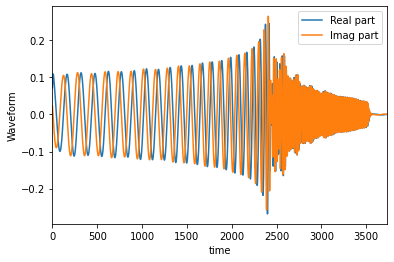

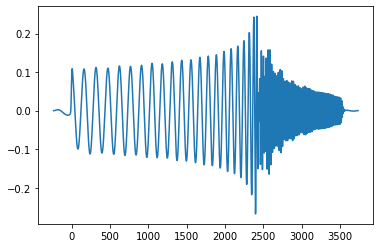

In [5]:
current_h5_file = h5py.File(os.path.join(sel_data.path, sel_data.dfile), "r")
print(current_h5_file.keys())
sel_data.show("rh_22")
plt.show()
dset = sel_data.read("rh_22")
fig = plt.plot(dset[:, 0], dset[:, 1])  # gets the real data
plt.show()

5574 5574


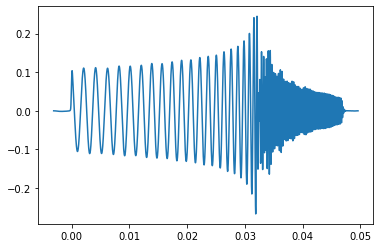

In [6]:
# print(current_h5_file["rh_22"].keys())
npds = current_h5_file["rh_22"]["Rh_l2_m2_rInf.txt"]
# print(npds)
# print(sel_data.mdata.data)
# fig1 = plt.figure(figsize=(20, 15))\

print(len(npds[:,0]),len(npds[:,1]))
plt.plot(
    npds[:, 0]*(4.925*10**-6*float(sel_md["id_mass"])),
    npds[:,1],
)
# fig, ax = sel_data.show("rh_22")
# fig.set_size_inches(20, 15)
# print(npds[:,1],len(npds[:,1]))

In [7]:
from scipy import signal
from scipy.fft import fftshift
from scipy.cluster.vq import whiten
import matplotlib.pyplot as plt
print(len(npds[:,1]),len(npds[:,0]))
cnpds = npds[:,1]
tsig = npds[:,0]
total_mass_multiplier = (4.925*10**-6*float(sel_md["id_mass"]))




5574 5574


['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']


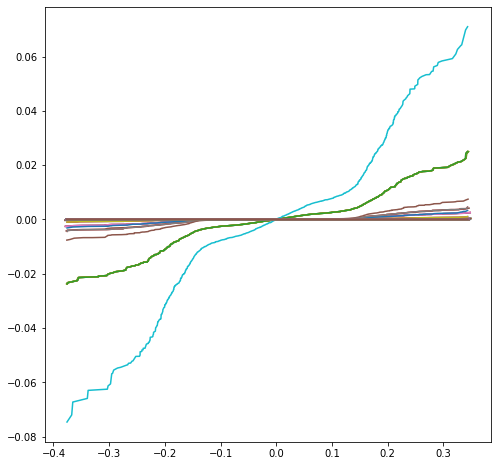

In [17]:
import pywt
print(pywt.families())
fig, ax = plt.subplots(figsize=(8, 8))
for i in pywt.wavelist(kind="discrete"):
    a,b = pywt.dwt(cnpds,i)
    ax.plot(sorted(a),sorted(b))
plt.show()

C:\Users\aashr\AppData\Local\Temp\ipykernel_10740\4098797510.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(t*total_mass_multiplier, fftshift(f), fftshift(Sxx, axes=0))


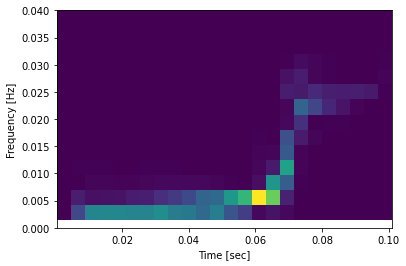

In [20]:
f, t, Sxx = signal.spectrogram(cnpds,fs = (tsig[-1]-tsig[0])/len(tsig))
plt.pcolormesh(t*total_mass_multiplier, fftshift(f), fftshift(Sxx, axes=0))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim((0,.04))
plt.show()


In [10]:
Msun_sec = 4.925794970773135e-06
w = wave(
    path=sel_data.path,
    code="core",
    filename="Rpsi4_l2_m2_r00400.txt",
    mass=float(sel_data.mdata.data["id_rest_mass"]),
    f0=float(sel_data.mdata.data["id_gw_frequency_Hz"]) * Msun_sec,
)
import glob

fnames = [
    os.path.split(x)[1] for x in glob.glob("{}/{}".format(sel_data.path, "Rpsi4_*.txt"))
]
print(fnames)
wm = mwaves(
    path=sel_data.path,
    code="core",
    filenames=fnames,
    mass=float(sel_data.mdata.data["id_rest_mass"]),
    f0=float(sel_data.mdata.data["id_gw_frequency_Hz"]) * Msun_sec,
    ignore_negative_m=True,
)
print(wm.modes)
sel_data.mdata.data["id_gw_frequency_Hz"]

['Rpsi4_l2_m2_r00400.txt', 'Rpsi4_l2_m2_r00500.txt', 'Rpsi4_l2_m2_r00600.txt', 'Rpsi4_l2_m2_rInf.txt']
[(2, 2)]


'454.5535788'

In [ ]:

import pandas as pd
df = pd.DataFrame(columns=["m1","m2","eos"])

for i in ordered_by_eos:
    for j in (ordered_by_eos[i]):
        # plt.scatter(float(j["m1"]),float(j["m2"]))
        df = df.append({
            "m1":float(j["m1"]),
            "m2":float(j["m2"]),
            "eos":j["id_eos"]
        },ignore_index=True)


In [2]:
plt.scatter(df["m1"], df["m2"],figsize=(10,10))

NameError: name 'plt' is not defined

In [1]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(10, 10))
for c,i in enumerate(set(np.array(df["eos"]))):
    tdf = df[df['eos'].str.contains(i)]
    ax.scatter(tdf["m1"], tdf["m2"],marker=list(Line2D.markers.items())[c][0])


NameError: name 'plt' is not defined

In [14]:
print(df["eos"])

0       2B
1       2B
2       2B
3       2B
4       2H
      ... 
362    SLY
363    SLY
364    SLY
365    SLY
366    SLY
Name: eos, Length: 367, dtype: object
